In [146]:
# Imports

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from collections import Counter

In [136]:
# Use Apple MPS (Mac GPU) if available, otherwise fallback to CPU

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


In [137]:
# Dataset Path

path = '/Users/abdulrahman/Downloads/brain_tumor_dataset'

In [138]:
os.listdir(path)

['pituitary', '.DS_Store', 'healthy', 'glioma', 'meningioma']

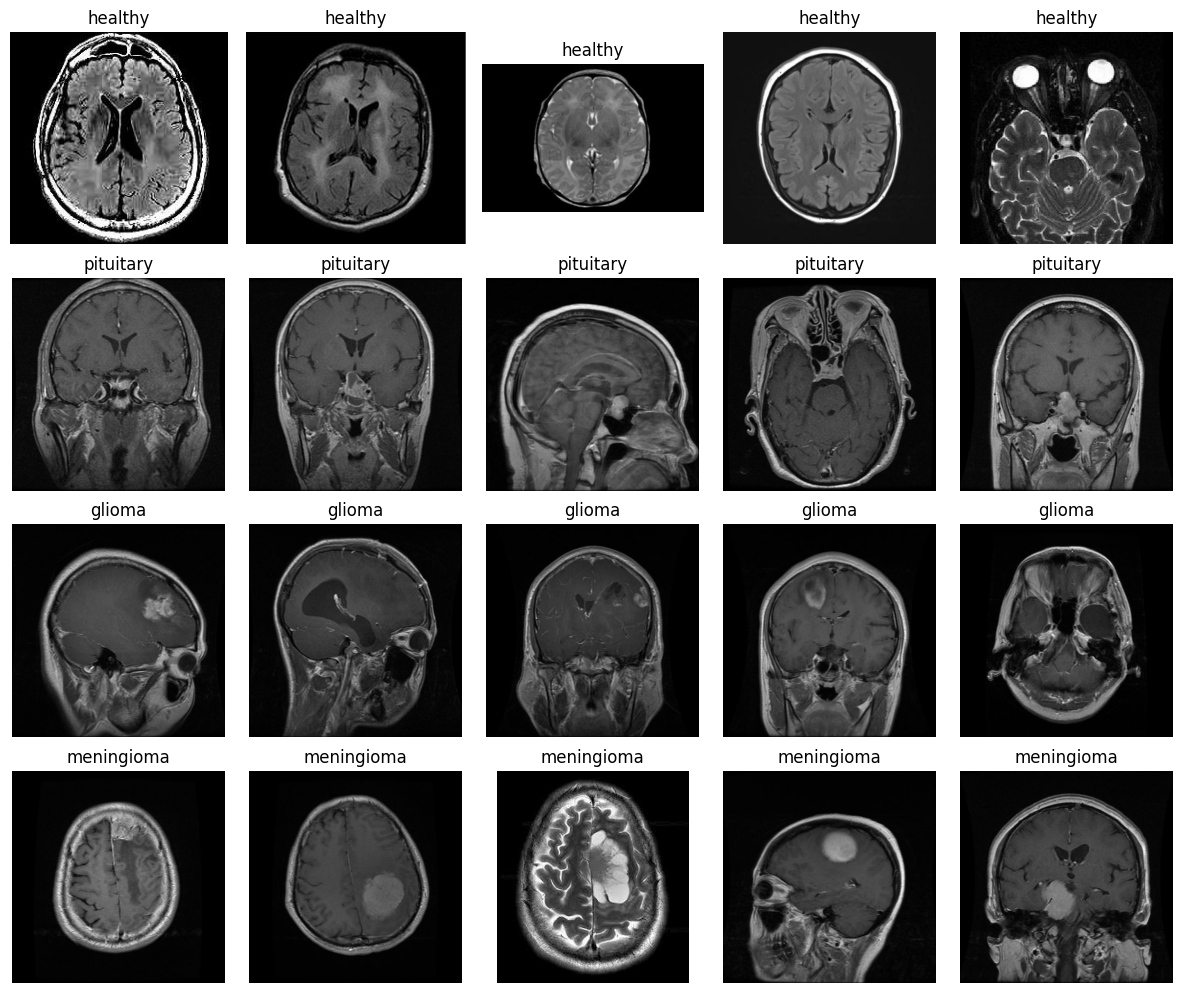

In [144]:
# Visualize Sample Images

plt.figure(figsize=(12, 10))
classes = os.listdir(path)

img_count = 0
for cls in ['healthy', 'pituitary', 'glioma', 'meningioma']:
    cls_path = os.path.join(path, cls)
    for img in os.listdir(cls_path)[:5]:
        img_count += 1
        img_path = os.path.join(cls_path, img)
        image = plt.imread(img_path)
        plt.subplot(4, 5, img_count)
        plt.imshow(image)
        plt.title(cls)
        plt.axis("off")

plt.tight_layout()
plt.show()

In [139]:
# Custome Dataset Class

class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transforms = transform
        self.image_paths = []
          self.labels = []
        
        self.class_to_idx = {
            'healthy': 0,
            'pituitary': 1,
            'glioma': 2,
            'meningioma': 3
        }
        
        self._load_dataset()
    
    def _load_dataset(self):
        for condition in ['healthy', 'pituitary', 'glioma', 'meningioma']:
            condition_path = os.path.join(self.root_dir, condition)
            if not os.path.isdir(condition_path):
                continue
            label = self.class_to_idx[condition]
            for img_name in os.listdir(condition_path):
                if img_name.lower().endswith(('png', 'jpg', 'jpeg')):
                    self.image_paths.append(os.path.join(condition_path, img_name))
                    self.labels.append(label)
    
    def __len__(self):
        return len(self.image_paths)
         
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [140]:
dataset = BrainTumorDataset(path)

In [141]:
# Dataset Splitting

total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, 
    [train_size, val_size, test_size]
)

In [90]:
# Compete Dataset Mean & STD

def compute_mean_std(loader):
    mean = torch.zeros(1)
    std = torch.zeros(1)
    total_pixels = 0
    
    with torch.no_grad():
        for images, _ in loader:
            batch_pixels = images.numel() / images.size(1)
            total_pixels += batch_pixels

            mean += images.sum(dim=[0, 2, 3])
            std += (images ** 2).sum(dim=[0, 2, 3])
    
    mean /= total_pixels
    std = (std / total_pixels - mean ** 2).sqrt()
    
    return mean, std

In [91]:
# Temporary transforms for statistics

temp_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

train_dataset.dataset.transform = temp_transforms

temp_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=False
)

mean, std = compute_mean_std(temp_loader)

print('Mean: ', mean)
print('STD: ', std)

Mean:  tensor([0.1859])
STD:  tensor([0.2008])


In [92]:
# Final Image Transformations

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean = mean, std = std)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [93]:
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

In [94]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
)

In [95]:
# CNN Model Defination

class BrainTumorClassification(nn.Module):
    def __init__(self, num_classes=4):
        
        super(BrainTumorClassification, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
        

In [96]:
model = BrainTumorClassification()

In [97]:
# Handle Class Imbalance

labels = train_dataset.dataset.labels

counts = Counter(labels)
total = sum(counts.values())

class_weights = [total/counts[i] for i in range(len(counts))]
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

print('Class Weights: ', class_weights)

Class Weights:  tensor([3.5115, 3.9972, 4.3325, 4.2693], device='mps:0')


In [98]:
loss_fcn = nn.CrossEntropyLoss(class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [99]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [100]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return (preds == labels).sum().item() / labels.size(0)

In [103]:
# Training Loop

def training_loop(model, train_loader, val_loader, loss_fcn, optimizer, n_epochs=20, scheduler=None, early_stopping_patience = 5, save_path='best_model.pth'):
    
    model.to(device)
    
    best_val_loss = np.inf
    epochs_no_improve = 0
        
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    print('---Starting Training---')

    for epoch in range(1, n_epochs + 1):
        model.train()
        running_train_loss = 0.0
        running_train_acc = 0.0
        train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch}/{n_epochs} [Training]', leave=True)
        
        for batch_idx, (images, labels) in enumerate(train_progress_bar):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fcn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()
            running_train_acc += accuracy(outputs, labels)
            
            train_progress_bar.set_postfix(loss=running_train_loss/(batch_idx+1),
                                           acc=running_train_acc/(batch_idx+1))
        
        train_loss = running_train_loss / len(train_loader)
        train_acc = running_train_acc / len(train_loader)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        model.eval()
        with torch.no_grad():
            running_val_loss = 0.0
            running_val_acc = 0.0
            val_progress_bar = tqdm(val_loader, desc=f'Epoch {epoch}/{n_epochs} [Validating]', leave=True)
            
            for data_idx, (images, labels) in enumerate(val_progress_bar):
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = loss_fcn(outputs, labels)
                
                running_val_loss += loss.item()
                running_val_acc += accuracy(outputs, labels)
                
                val_progress_bar.set_postfix(loss=running_val_loss/(batch_idx+1),
                                             acc=running_val_acc/(batch_idx+1))
                
        val_loss = running_val_loss / len(val_loader)
        val_acc = running_val_acc / len(val_loader)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f'Epoch {epoch}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, '
              f'Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}')
            
        if scheduler:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            epochs_no_improve = 0
        
        else:
            epochs_no_improve += 1
            
        if early_stopping_patience and epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch} epochs")
            break
            
            
    print('---Training Finished---')
    
    return train_losses, train_accs, val_losses, val_accs
        

In [104]:
train_losses, train_accs, val_losss, val_accs = training_loop(model, train_loader, val_loader, loss_fcn, optimizer, 30, scheduler, )

---Starting Training---


Epoch 1/30 [Training]: 100%|█| 154/154 [00:56<00:00,  2.71it/s, acc=0.685, loss=
Epoch 1/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  7.35it/s, acc=0.174, loss=


Epoch 1: Train Loss=0.7511, Train Acc=0.6847, Val Loss=0.5328, Val Acc=0.8118


Epoch 2/30 [Training]: 100%|█| 154/154 [00:56<00:00,  2.73it/s, acc=0.74, loss=0
Epoch 2/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  7.92it/s, acc=0.18, loss=0


Epoch 2: Train Loss=0.6413, Train Acc=0.7396, Val Loss=0.4400, Val Acc=0.8380


Epoch 3/30 [Training]: 100%|█| 154/154 [00:56<00:00,  2.73it/s, acc=0.749, loss=
Epoch 3/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  7.94it/s, acc=0.181, loss=


Epoch 3: Train Loss=0.6158, Train Acc=0.7491, Val Loss=0.4192, Val Acc=0.8463


Epoch 4/30 [Training]: 100%|█| 154/154 [00:56<00:00,  2.75it/s, acc=0.757, loss=
Epoch 4/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  7.90it/s, acc=0.184, loss=


Epoch 4: Train Loss=0.5874, Train Acc=0.7567, Val Loss=0.3701, Val Acc=0.8604


Epoch 5/30 [Training]: 100%|█| 154/154 [00:56<00:00,  2.73it/s, acc=0.769, loss=
Epoch 5/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  7.85it/s, acc=0.185, loss=


Epoch 5: Train Loss=0.5596, Train Acc=0.7686, Val Loss=0.3579, Val Acc=0.8653


Epoch 6/30 [Training]: 100%|█| 154/154 [00:56<00:00,  2.74it/s, acc=0.785, loss=
Epoch 6/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  7.91it/s, acc=0.188, loss=


Epoch 6: Train Loss=0.5355, Train Acc=0.7854, Val Loss=0.4761, Val Acc=0.8776


Epoch 7/30 [Training]: 100%|█| 154/154 [00:56<00:00,  2.72it/s, acc=0.794, loss=
Epoch 7/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  7.62it/s, acc=0.185, loss=


Epoch 7: Train Loss=0.5043, Train Acc=0.7940, Val Loss=0.3527, Val Acc=0.8634


Epoch 8/30 [Training]: 100%|█| 154/154 [00:58<00:00,  2.62it/s, acc=0.809, loss=
Epoch 8/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  7.55it/s, acc=0.19, loss=0


Epoch 8: Train Loss=0.4682, Train Acc=0.8090, Val Loss=0.2768, Val Acc=0.8881


Epoch 9/30 [Training]: 100%|█| 154/154 [00:57<00:00,  2.68it/s, acc=0.795, loss=
Epoch 9/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  7.66it/s, acc=0.19, loss=0


Epoch 9: Train Loss=0.5161, Train Acc=0.7953, Val Loss=0.2910, Val Acc=0.8869


Epoch 10/30 [Training]: 100%|█| 154/154 [00:56<00:00,  2.74it/s, acc=0.803, loss
Epoch 10/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  7.99it/s, acc=0.186, loss


Epoch 10: Train Loss=0.4676, Train Acc=0.8026, Val Loss=0.3598, Val Acc=0.8700


Epoch 11/30 [Training]: 100%|█| 154/154 [00:56<00:00,  2.74it/s, acc=0.832, loss
Epoch 11/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  7.86it/s, acc=0.19, loss=


Epoch 11: Train Loss=0.4236, Train Acc=0.8321, Val Loss=0.3033, Val Acc=0.8880


Epoch 12/30 [Training]: 100%|█| 154/154 [00:56<00:00,  2.71it/s, acc=0.83, loss=
Epoch 12/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  7.90it/s, acc=0.191, loss


Epoch 12: Train Loss=0.4323, Train Acc=0.8296, Val Loss=0.3049, Val Acc=0.8899


Epoch 13/30 [Training]: 100%|█| 154/154 [00:56<00:00,  2.75it/s, acc=0.861, loss
Epoch 13/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  7.92it/s, acc=0.198, loss


Epoch 13: Train Loss=0.3456, Train Acc=0.8611, Val Loss=0.2291, Val Acc=0.9223


Epoch 14/30 [Training]: 100%|█| 154/154 [00:56<00:00,  2.74it/s, acc=0.871, loss
Epoch 14/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  7.90it/s, acc=0.195, loss


Epoch 14: Train Loss=0.3140, Train Acc=0.8711, Val Loss=0.2358, Val Acc=0.9108


Epoch 15/30 [Training]: 100%|█| 154/154 [00:56<00:00,  2.72it/s, acc=0.883, loss
Epoch 15/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  7.82it/s, acc=0.197, loss


Epoch 15: Train Loss=0.2858, Train Acc=0.8835, Val Loss=0.2103, Val Acc=0.9203


Epoch 16/30 [Training]: 100%|█| 154/154 [00:56<00:00,  2.73it/s, acc=0.896, loss
Epoch 16/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  7.90it/s, acc=0.197, loss


Epoch 16: Train Loss=0.2616, Train Acc=0.8957, Val Loss=0.2075, Val Acc=0.9175


Epoch 17/30 [Training]: 100%|█| 154/154 [00:56<00:00,  2.74it/s, acc=0.896, loss
Epoch 17/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  7.91it/s, acc=0.2, loss=0


Epoch 17: Train Loss=0.2587, Train Acc=0.8964, Val Loss=0.1991, Val Acc=0.9336


Epoch 18/30 [Training]: 100%|█| 154/154 [00:56<00:00,  2.74it/s, acc=0.9, loss=0
Epoch 18/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  7.93it/s, acc=0.197, loss


Epoch 18: Train Loss=0.2459, Train Acc=0.8999, Val Loss=0.2121, Val Acc=0.9204


Epoch 19/30 [Training]: 100%|█| 154/154 [00:55<00:00,  2.75it/s, acc=0.906, loss
Epoch 19/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  7.85it/s, acc=0.198, loss


Epoch 19: Train Loss=0.2294, Train Acc=0.9062, Val Loss=0.2419, Val Acc=0.9250


Epoch 20/30 [Training]: 100%|█| 154/154 [00:56<00:00,  2.74it/s, acc=0.906, loss
Epoch 20/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  7.90it/s, acc=0.197, loss


Epoch 20: Train Loss=0.2319, Train Acc=0.9058, Val Loss=0.2575, Val Acc=0.9203


Epoch 21/30 [Training]: 100%|█| 154/154 [00:58<00:00,  2.62it/s, acc=0.907, loss
Epoch 21/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  7.72it/s, acc=0.2, loss=0


Epoch 21: Train Loss=0.2413, Train Acc=0.9074, Val Loss=0.2042, Val Acc=0.9346


Epoch 22/30 [Training]: 100%|█| 154/154 [00:56<00:00,  2.74it/s, acc=0.921, loss
Epoch 22/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  7.92it/s, acc=0.201, loss


Epoch 22: Train Loss=0.2027, Train Acc=0.9209, Val Loss=0.1741, Val Acc=0.9401


Epoch 23/30 [Training]: 100%|█| 154/154 [00:57<00:00,  2.69it/s, acc=0.934, loss
Epoch 23/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  7.68it/s, acc=0.203, loss


Epoch 23: Train Loss=0.1695, Train Acc=0.9339, Val Loss=0.1717, Val Acc=0.9469


Epoch 24/30 [Training]: 100%|█| 154/154 [00:58<00:00,  2.63it/s, acc=0.933, loss
Epoch 24/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  6.71it/s, acc=0.201, loss


Epoch 24: Train Loss=0.1648, Train Acc=0.9333, Val Loss=0.1850, Val Acc=0.9374


Epoch 25/30 [Training]: 100%|█| 154/154 [00:56<00:00,  2.72it/s, acc=0.932, loss
Epoch 25/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  7.95it/s, acc=0.202, loss


Epoch 25: Train Loss=0.1609, Train Acc=0.9319, Val Loss=0.1946, Val Acc=0.9421


Epoch 26/30 [Training]: 100%|█| 154/154 [00:56<00:00,  2.73it/s, acc=0.932, loss
Epoch 26/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  7.86it/s, acc=0.204, loss


Epoch 26: Train Loss=0.1614, Train Acc=0.9320, Val Loss=0.1874, Val Acc=0.9497


Epoch 27/30 [Training]: 100%|█| 154/154 [00:56<00:00,  2.72it/s, acc=0.934, loss
Epoch 27/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  7.12it/s, acc=0.202, loss


Epoch 27: Train Loss=0.1582, Train Acc=0.9335, Val Loss=0.1990, Val Acc=0.9412


Epoch 28/30 [Training]: 100%|█| 154/154 [00:58<00:00,  2.63it/s, acc=0.947, loss
Epoch 28/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  6.61it/s, acc=0.202, loss


Epoch 28: Train Loss=0.1366, Train Acc=0.9472, Val Loss=0.1679, Val Acc=0.9450


Epoch 29/30 [Training]: 100%|█| 154/154 [00:57<00:00,  2.66it/s, acc=0.947, loss
Epoch 29/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  7.68it/s, acc=0.202, loss


Epoch 29: Train Loss=0.1348, Train Acc=0.9465, Val Loss=0.1740, Val Acc=0.9450


Epoch 30/30 [Training]: 100%|█| 154/154 [00:56<00:00,  2.74it/s, acc=0.951, loss
Epoch 30/30 [Validating]: 100%|█| 33/33 [00:04<00:00,  7.85it/s, acc=0.203, loss

Epoch 30: Train Loss=0.1176, Train Acc=0.9511, Val Loss=0.1810, Val Acc=0.9488
---Training Finished---


In [150]:
# Evaluation

def evaluate(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            pred = torch.argmax(outputs, dim=1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
            
    acc = accuracy_score(y_true, y_pred)
    
    report = classification_report(
        y_true, y_pred,
        target_names = ['healty', 'pituitary', 'glioma', 'meningioma']
    )
    
    cm = confusion_matrix(y_true, y_pred)
    
    return acc, report, cm

In [151]:
test_acc, test_report, test_cm = evaluate(model, test_loader, device)

print(f"Test Accuracy: {test_acc:.4f}")
print("\nClassification Report:\n", test_report)
print("\nConfusion Matrix:\n", test_cm)

Test Accuracy: 0.9421

Classification Report:
               precision    recall  f1-score   support

      healty       0.96      0.97      0.97       311
   pituitary       0.98      0.97      0.98       256
      glioma       0.95      0.91      0.93       242
  meningioma       0.87      0.91      0.89       245

    accuracy                           0.94      1054
   macro avg       0.94      0.94      0.94      1054
weighted avg       0.94      0.94      0.94      1054


Confusion Matrix:
 [[302   3   1   5]
 [  0 249   0   7]
 [  0   1 220  21]
 [ 11   1  11 222]]


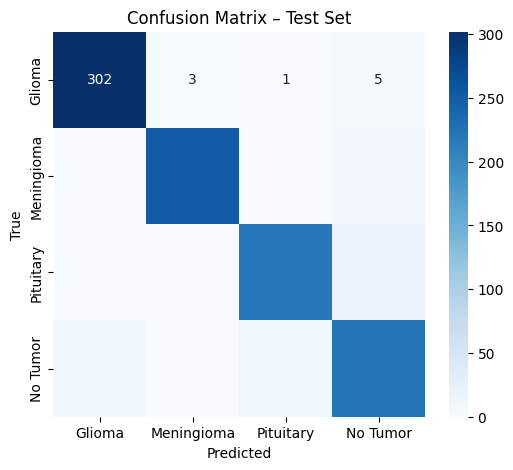

In [152]:
plt.figure(figsize=(6,5))
sns.heatmap(
    test_cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['healthy','pituitary','glioma','meningioma'],
    yticklabels=['healthy','pituitary','glioma','meningioma']
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix – Test Set')
plt.show()

In [153]:
# Save Final Model
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': ['healthy','pituitary','glioma','meningioma'],
    'val_accuracy': 0.9488
}, 'brain_tumor_cnn.pth')
